In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.use('TkAgg')

from glob import glob
from dea_tools.temporal import temporal_statistics, xr_phenology
from dea_tools.spatial import xr_rasterize
from utils import calculate_indices, open_ncs

from mpl_toolkits.axes_grid1 import host_subplot
import datetime as dt



%matplotlib inline

Começando pela fazenda da MaVi

-18.07179°,-50.79121°

In [2]:
folder = '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/'
files = sorted(glob(f'{folder}/L*.nc'))
files

['/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2013-06-25_2014-06-12.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2014-06-21_2015-06-15.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2015-06-24_2016-06-17.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2016-06-26_2017-06-20.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2017-06-29_2018-06-16.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2018-06-23_2019-06-19.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2019-06-26_2020-06-12.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2020-06-21_2021-06-15.nc',
 '/mnt/geodata/Clientes/0FARMS/9a151331-1b50-4804-b416-c217d45d6ac6/Landsat_002_2021-06-24_2022-06-03.nc',
 '/mnt/geodata/Clientes/0FARMS/9a1513

In [3]:
ds = open_ncs(folder)
ds

FrozenMappingWarningOnValuesAccess({'time': 70, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 66, 'latitude': 198, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 71, 'latitude': 198, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 74, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 69, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 69, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 73, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 68, 'latitude': 198, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 102, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 126, 'latitude': 199, 'longitude': 332})
FrozenMappingWarningOnValuesAccess({'time': 168, 'latitude': 198, 'longitude': 332})


<xarray.Dataset> Size: 758MB
Dimensions:                       (time: 956, latitude: 199, longitude: 332)
Coordinates: (12/20)
  * longitude                     (longitude) float64 3kB -50.81 ... -50.72
  * latitude                      (latitude) float64 2kB -18.05 -18.05 ... -18.1
  * time                          (time) datetime64[ns] 8kB 2013-06-25T13:29:...
    landsat:collection_category   <U2 8B ...
    landsat:scene_id              (time) <U21 80kB 'LC82230722013176LGN01' .....
    accuracy:geometric_y_bias     int64 8B ...
    ...                            ...
    full_width_half_max           float64 8B ...
    view:sun_elevation            (time) float64 8kB 40.03 40.21 ... 41.05 39.8
    card4l:specification_version  <U3 12B ...
    platform                      (time) <U9 34kB 'LANDSAT_8' ... 'LANDSAT_8'
    id                            (time) <U43 164kB 'LC08_L2SP_223072_2013062...
    spatial_ref                   int64 8B 0
Data variables:
    red                           (time, latitude, longitude) uint16 126MB 97...
    blue                          (time, latitude, longitude) uint16 126MB 87...
    nir08                         (time, latitude, longitude) uint16 126MB 16...
    swir16                        (time, latitude, longitude) uint16 126MB 17...
    qa_pixel                      (time, latitude, longitude) uint16 126MB 21...
    T                             (time, latitude, longitude) uint16 126MB 45...

In [5]:
ds.time.values[800:815]

array(['2023-07-15T13:27:05.326822000', '2023-07-15T13:27:29.268669000',
       '2023-07-16T13:21:00.584829000', '2023-07-16T13:21:24.522465000',
       '2023-07-23T13:27:13.648707000', '2023-07-23T13:27:37.590579000',
       '2023-07-24T13:20:52.769438000', '2023-07-24T13:21:16.707049000',
       '2023-07-31T13:27:10.598509000', '2023-07-31T13:27:34.527648000',
       '2023-08-01T13:21:08.877326000', '2023-08-01T13:21:32.810725000',
       '2023-08-08T13:27:20.500988000', '2023-08-08T13:27:44.434388000',
       '2023-08-09T13:21:04.373783000'], dtype='datetime64[ns]')

In [34]:
ds1 = ds.resample(time='W').max(skipna=True)

In [35]:
ds1

<xarray.Dataset> Size: 917MB
Dimensions:                       (longitude: 332, latitude: 199, time: 578)
Coordinates: (12/13)
  * longitude                     (longitude) float64 3kB -50.81 ... -50.72
  * latitude                      (latitude) float64 2kB -18.05 -18.05 ... -18.1
  * time                          (time) datetime64[ns] 5kB 2013-06-30 ... 20...
    landsat:collection_category   <U2 8B 'T1'
    accuracy:geometric_y_bias     int64 8B 0
    card4l:specification          <U2 8B 'SR'
    ...                            ...
    view:off_nadir                int64 8B 0
    epsg                          int64 8B 4326
    proj:epsg                     int64 8B 32622
    full_width_half_max           float64 8B nan
    card4l:specification_version  <U3 12B '5.0'
    spatial_ref                   int64 8B 0
Data variables:
    red                           (time, latitude, longitude) float32 153MB 9...
    blue                          (time, latitude, longitude) float32 153MB 8...
    nir08                         (time, latitude, longitude) float32 153MB 1...
    swir16                        (time, latitude, longitude) float32 153MB 1...
    qa_pixel                      (time, latitude, longitude) float32 153MB 2...
    T                             (time, latitude, longitude) float32 153MB 4...

In [48]:
vis = calculate_indices( ds1 , index = ['kNDVI','NDVI','LAI'], drop = True, collection = 'Landsat')
vis['kNDVI'] = xr.where(vis['kNDVI'] > 0.4, np.nan, vis['kNDVI'])
vis['NDVI'] = xr.where((vis['NDVI'] > 0.74) | (vis['NDVI'] < -0.05), np.nan, vis['NDVI'])
vis['LAI'] = xr.where((vis['LAI'] > 7.4) | (vis['LAI'] < 0), np.nan, vis['LAI'])


Dropping bands {'red', 'qa_pixel', 'blue', 'T', 'nir08', 'swir16'}


In [64]:
xr.corr(vis['LAI'],vis['NDVI'], dim='time').values.mean()

0.95427525

In [60]:
corr.values.mean()

0.9607956

In [49]:
days = 50
vis.to_netcdf(f'{folder}/vis_raw.nc')
for window in [1,3,5]:
    vis_f1 = vis.interpolate_na( dim = 'time' , 
                                   method =  'pchip', # pchip , spline
                                    max_gap = np.timedelta64( days , 'D' )
                                    ).rolling(time=window).mean(skipna=True)
    vis_f1.to_netcdf(f'{folder}/vis_mgdays_{days}_window_{window}.nc')

In [50]:
vis_f1.time.values[0]

numpy.datetime64('2013-06-30T00:00:00.000000000')

In [11]:
x , y = -50.79121 , -18.07179

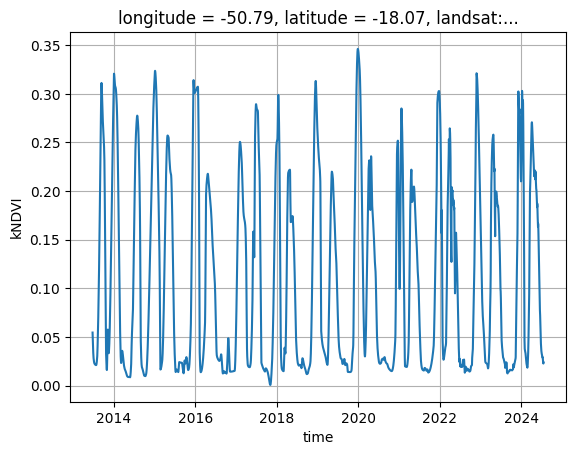

In [19]:
days = 80
vis['kNDVI'] = xr.where(vis['kNDVI'] > 0.4, np.nan, vis['kNDVI'])
vis['kNDVI'].sel(longitude = x, latitude = y, method='nearest').interpolate_na( dim = 'time' , 
                               method =  'pchip', # pchip , spline
                                max_gap = np.timedelta64( days , 'D' )
                                ).rolling(time=1).mean(skipna=True).plot();plt.grid();plt.show();plt.close('all')

In [29]:
vis_w = vis.resample(time='W').mean(skipna=True).rolling(time=3).mean()

In [30]:
vis_w.to_netcdf(folder+'kndvi_2day2week.nc')

In [ ]:
days = 80
vis['kNDVI'].sel(time=slice('2014-04-01','2014-10-21')).sel( 
    longitude = x, latitude = y, method='nearest'
    ).plot();plt.grid();plt.show();plt.close('all')

In [ ]:
days = 80
dstest = vis['kNDVI'].sel(time=slice('2014-04-01','2014-10-21')).interpolate_na(dim = 'time' , 
                                method =  'pchip', # pchip , spline
                                max_gap = np.timedelta64( days , 'D' ))
dstest.sel( longitude = x, latitude = y, method='nearest').plot();plt.grid();plt.show();plt.close('all')

In [ ]:
basic_pheno_stats = [
    "SOS",
    "vSOS",
    "POS",
    "vPOS",
    "EOS",
    "vEOS",
    "Trough",
    "LOS",
    "AOS",
    "ROG",
    "ROS",
]
method_sos = "first"
method_eos = "last"

In [ ]:
years = dstest.groupby("time.year")

# get list of years in ts to help with looping
years_int = [y[0] for y in years]

# store results in dict
pheno_results = {}

# loop through years and calculate phenology
for year in years_int:
    # select year
    da = dict(years)[year]

    # calculate stats
    stats = xr_phenology(
        da,
        method_sos=method_sos,
        method_eos=method_eos,
        stats=basic_pheno_stats,
        verbose=False,
    )
    # add results to dict
    pheno_results[str(year)] = stats

In [ ]:
stats['LOS'].plot(cmap='RdYlBu', robust=True)
plt.title(feno);plt.show();plt.close() 

In [ ]:
for feno in ['SOS','POS','EOS']:
    stats[feno].plot(cmap='hsv')
    plt.title(feno);plt.show();plt.close()

In [ ]:
for feno in ['vSOS','vPOS','vEOS']:
    stats[feno].plot(cmap='RdYlBu', robust=True)
    plt.title(feno);plt.show();plt.close() 

In [ ]:
stats['ROG'].plot(cmap='RdYlBu', robust=True)
plt.title(feno);plt.show();plt.close() 

In [ ]:
stats['ROS'].plot(cmap='RdYlBu', robust=True)
plt.title(feno);plt.show();plt.close() 

In [ ]:
stats['Trough'].plot(cmap='RdYlBu', robust=True)
plt.show();plt.close() 

In [ ]:
years_int

In [ ]:
year_to_plot = '2014'
veg_proxy = 'kNDVI'

In [ ]:
phen = pheno_results[year_to_plot]

# Define a few items to aid in plotting.
start_date = dt.date(int(year_to_plot), 1, 1)
end_date = dt.date(int(year_to_plot), 10, 27)

date_list = pd.date_range(start_date, end_date, freq="MS")
bounds = [int(i.strftime("%Y%m%d")) for i in date_list]


@matplotlib.ticker.FuncFormatter
def float_to_date(x, pos):
    tick_str = str(int(x))
    year = tick_str[:4]
    month = tick_str[4:6]
    day = tick_str[6:]
    return f"{year}-{month}-{day}"


# set up figure
fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(18, 8),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect("equal")

# start of season
# Convert SOS values from np.date64 to float values for plotting
cax = phen.SOS.dt.dayofyear.plot( 
    ax=ax[0, 0],
    cmap="magma_r",
#     levels=bounds,
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 0].set_title("Start of Season")

phen.vSOS.plot(ax=ax[0, 1],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title(veg_proxy + " at SOS")

# peak of season
# # Convert POS values from np.date64 to float values for plotting
cax = phen.POS.dt.dayofyear.plot(
    ax=ax[0, 2],
    cmap="magma_r",
#     levels=bounds,
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 2].set_title("Peak of Season")

phen.vPOS.plot(ax=ax[0, 3],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 3].set_title( + " at POS")

# end of season
# Convert EOS values from np.date64 to float values for plotting
cax = phen.EOS.dt.dayofyear.plot( 
    ax=ax[0, 4],
    cmap="magma_r",
#     levels=bounds,
    add_colorbar=True,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[0, 4].set_title("End of Season")

phen.vEOS.plot(ax=ax[1, 0],
               cmap="YlGn",
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title(veg_proxy + " at EOS")

# Length of Season
phen.LOS.plot(
    ax=ax[1, 1],
    cmap="magma_r",
    vmax=300,
    vmin=0,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 1].set_title("Length of Season (Days)")

# Amplitude
phen.AOS.plot(ax=ax[1, 2],
              cmap="YlGn",
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 2].set_title("Amplitude of Season")

# rate of growth
phen.ROG.plot(
    ax=ax[1, 3],
    cmap="coolwarm_r",
    vmin=-0.02,
    vmax=0.02,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 3].set_title("Rate of Growth")

# rate of Sensescence
phen.ROS.plot(
    ax=ax[1, 4],
    cmap="coolwarm_r",
    vmin=-0.02,
    vmax=0.02,
    cbar_kwargs=dict(shrink=cbar_size, label=None),
)
ax[1, 4].set_title("Rate of Senescence")
plt.suptitle("Phenology for " + year_to_plot)
plt.tight_layout();